## NetCDF and Superdoves data

Want to load SD data directly into python rather than using SNAP.

In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dalecLoad
import spectralConv
import SD_raster_loading


In [24]:
directory = 'C:/Users/daa5/\
OneDrive - University of Stirling/\
PlanetData/\
Airthrey-20-Jun-22-TOAR_psscene_analytic_8b_udm2/\
acolite_output/'

file = 'PlanetScope_2423_2022_06_20_10_29_24_L2R.nc'

f = netCDF4.Dataset(directory+file)
print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    generated_by: ACOLITE
    generated_on: 2022-06-28 16:57:38 GMT Summer Time
    contact: Quinten Vanhellemont
    product_type: NetCDF
    metadata_profile: beam
    metadata_version: 0.5
    auto_grouping: rhot:rhorc:rhos:rhow:Rrs
    Conventions: CF-1.7
    sensor: PlanetScope_SD8
    satellite_sensor: PlanetScope_2423
    isodate: 2022-06-20T10:29:24+00:00
    sza: 38.59084
    vza: 5.079193
    raa: 120.35622000000001
    se_distance: 1.0161655217748657
    mus: 0.7816202034092942
    acolite_file_type: L2R
    oname: PlanetScope_2423_2022_06_20_10_29_24
    ofile: C:/Users/daa5/OneDrive - University of Stirling/PlanetData/Airthrey-20-Jun-22-TOAR_psscene_analytic_8b_udm2/acolite_output/PlanetScope_2423_2022_06_20_10_29_24_L2R.nc
    Coastal-Blue_wave: 443.6610607244119
    Coastal-Blue_name: 444
    Coastal-Blue_f0: 19014.80145243501
    Blue_wave: 492.3012651262192
    Blue_name: 492
    Blue

In [25]:
print(f.variables.keys()) # get all variable names

dict_keys(['transverse_mercator', 'x', 'y', 'lon', 'lat', 'rhot_444', 'rhos_444', 'rhot_492', 'rhos_492', 'rhot_533', 'rhos_533', 'rhot_566', 'rhos_566', 'rhot_612', 'rhos_612', 'rhot_666', 'rhos_666', 'rhot_707', 'rhos_707', 'rhot_866', 'rhos_866'])


In [26]:
lat, lon = f.variables['lat'], f.variables['lon']
print(lat)
print(lon)
print(lat[:])

<class 'netCDF4._netCDF4.Variable'>
float32 lat(y, x)
    parameter: lat
    standard_name: latitude
    long_name: latitude
    units: degree_north
    grid_mapping: transverse_mercator
unlimited dimensions: 
current shape = (256, 384)
filling on, default _FillValue of 9.969209968386869e+36 used
<class 'netCDF4._netCDF4.Variable'>
float32 lon(y, x)
    parameter: lon
    standard_name: longitude
    long_name: longitude
    units: degree_east
    grid_mapping: transverse_mercator
unlimited dimensions: 
current shape = (256, 384)
filling on, default _FillValue of 9.969209968386869e+36 used
[[56.149654 56.149654 56.149654 ... 56.14979  56.14979  56.14979 ]
 [56.149628 56.149628 56.149628 ... 56.149765 56.149765 56.149765]
 [56.1496   56.1496   56.1496   ... 56.14974  56.14974  56.14974 ]
 ...
 [56.142838 56.142838 56.142838 ... 56.142975 56.142975 56.142975]
 [56.14281  56.14281  56.14281  ... 56.14295  56.14295  56.14295 ]
 [56.142784 56.142784 56.142784 ... 56.14292  56.14292  56.1429

In [27]:
latvals = lat[:]; lonvals = lon[:]

In [28]:
# a function to find the index of the point closest pt
# (in squared distance) to give lat/lon value.
def getclosest_ij(lats, lons, latpt, lonpt):
    # find squared distance of every point on grid
    dist_sq = (lats-latpt)**2 + (lons-lonpt)**2
    # 1D index of minimum dist_sq element
    minindex_flattened = dist_sq.argmin()
    # Get 2D index for latvals and lonvals arrays from 1D index
    return np.unravel_index(minindex_flattened, lats.shape)

# this coordinate is nearish the bridge
coord = [56.14744002273786, -3.920338580847495]

iy_min, ix_min = getclosest_ij(latvals, lonvals, coord[0], coord[1])
print(iy_min)
print(ix_min)

84
150


84 150


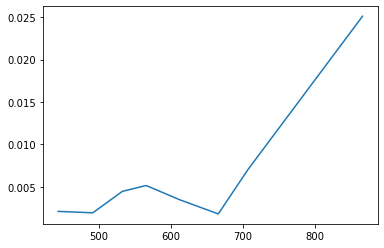

In [29]:
f.variables['rhos_444'][ix_min, iy_min]


def get_SD_NC_Spectra(NC_file, lat_pt, lon_pt):
    '''
    function to extract surface reflectance spectra from a superdoves NetCDF file at a given lat_pt, lon_pt coordinate
    '''
    lat, lon = NC_file.variables['lat'][:], f.variables['lon'][:]
    iy, ix = getclosest_ij(lat, lon, lat_pt, lon_pt)
    print(iy, ix)
    wavelengths = []
    rhos = []
    for var in list(NC_file.variables.keys()):
        # only interested in surface reflectance:
        if 'rhos' in var:
            wavelengths.append(float(var[5:]))
            rhos.append(NC_file.variables[var][iy, ix])
    
    df = pd.DataFrame(data={'Wavelength':wavelengths,
                     'Rho_s':rhos})
    return df
            

SD_spect = get_SD_NC_Spectra(f, coord[0], coord[1])           
plt.plot(SD_spect['Wavelength'], SD_spect['Rho_s']/np.pi)


In [30]:
def get_SD_NC_Spectra_grid(NC_file, lat_pt, lon_pt, shape=(3, 3)):
    '''
    function to extract surface reflectance spectra from a superdoves NetCDF file at a given lat_pt, lon_pt coordinate
    gets values from several pixels in a grid (with shape = shape) around the chosen coord
    '''
    lat, lon = NC_file.variables['lat'][:], f.variables['lon'][:]
    iy, ix = getclosest_ij(lat, lon, lat_pt, lon_pt)

    # get wavelengths data and create df for this
    wavelengths = []    
    for var in list(NC_file.variables.keys()):
        # only interested in surface reflectance:
        if 'rhos' in var:
            wavelengths.append(float(var[5:]))
            
    df1 = pd.DataFrame(data={'Wavelength':wavelengths})
                       
    # generate x and y coords for grid with shape=(shape[0], shape[1])
    x = np.linspace(ix - shape[0]//2,
                    ix + shape[0]//2 - (1 - shape[0]%2),
                    shape[0],
                    dtype=int)
    y = np.linspace(iy - shape[1]//2,
                    iy + shape[1]//2 - (1 - shape[1]%2),
                    shape[1],
                    dtype=int)
    rhos = []
    for i in x:
        for j in y:
            for var in list(NC_file.variables.keys()):
                # only interested in surface reflectance:
                if 'rhos' in var:
                    rhos.append(NC_file.variables[var][j, i])
            # might want to think about if I want to include the lat and lon of each pixel too?
            var_name = 'rho_s_' + str(i) + '_' + str(j)
            df2 = pd.DataFrame(data={var_name:rhos})
            df1 = pd.concat([df1, df2], axis=1)
            rhos = []
    return df1
            

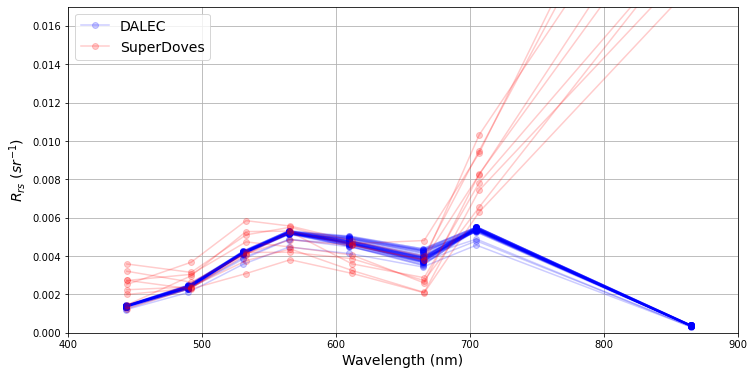

In [31]:
# get superdoves spectra near jetty
coord = [56.14720916748047, -3.92333722114563]


SD_spect = get_SD_NC_Spectra_grid(f, coord[0], coord[1], shape=(3, 3)) 

# get dalec spectra
tables = dalecLoad.multiLogLoad('data/20-jun-22/Logs_20-Jun-22_20220623.dtf', dropNA=False)
spect_wavelengths = dalecLoad.load_DALEC_spect_wavelengths('data/20-jun-22/Logs_20-Jun-22_20220623.dtf')
RSR_doves = pd.read_csv('non-DALEC-data/RSR-Superdove.csv')

# do plotting
fig, ax = plt.subplots(figsize=(12, 6))

for sample in tables['Log 2'].index.get_level_values('Sample #').unique():
    dalec_SD = spectralConv.SD_Rrs(RSR_doves,
                                   tables['Log 2'].loc[sample],
                                   spect_wavelengths)
    ax.plot(dalec_SD['Wavelength'],
             dalec_SD['Rrs'],
             marker='o',
             alpha=0.2,
             color='blue',
             label='DALEC')

for col in list(SD_spect.columns.values)[1:]:
    ax.plot(SD_spect['Wavelength'],
             SD_spect[col]/np.pi,
             color='red',
             label='SuperDoves',
             marker='o',
             alpha=0.2)
    
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('legend', fontsize=14) #fontsize of the legend

# this code removes duplicate labels in the legend. thanks stackoverflow!
handles, labels = ax.get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels)


ax.set_xlim(400, 900)
ax.set_ylim(0, 0.017)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('$R_{rs}$ $(sr^{-1}$)')
ax.grid()
plt.show()

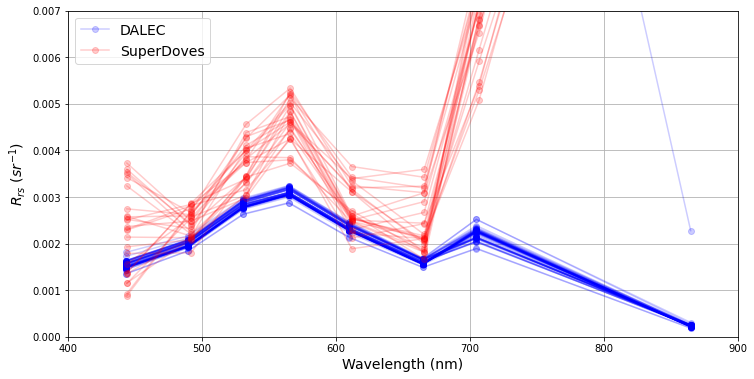

In [32]:
# get superdoves spectra near bridge
coord = [56.14725875854492, -3.920006513595581]


SD_spect = get_SD_NC_Spectra_grid(f, coord[0], coord[1], shape=(5, 5)) 

# get dalec spectra
tables = dalecLoad.multiLogLoad('data/20-jun-22/Logs_20-Jun-22_20220623.dtf', dropNA=False)
spect_wavelengths = dalecLoad.load_DALEC_spect_wavelengths('data/20-jun-22/Logs_20-Jun-22_20220623.dtf')
RSR_doves = pd.read_csv('non-DALEC-data/RSR-Superdove.csv')

# do plotting
fig, ax = plt.subplots(figsize=(12, 6))

for sample in tables['Log 1'].index.get_level_values('Sample #').unique():
    dalec_SD = spectralConv.SD_Rrs(RSR_doves,
                                   tables['Log 1'].loc[sample],
                                   spect_wavelengths)
    ax.plot(dalec_SD['Wavelength'],
             dalec_SD['Rrs'],
             marker='o',
             alpha=0.2,
             color='blue',
             label='DALEC')

for col in list(SD_spect.columns.values)[1:]:
    ax.plot(SD_spect['Wavelength'],
             SD_spect[col]/np.pi,
             color='red',
             label='SuperDoves',
             marker='o',
             alpha=0.2)
    
plt.rc('axes', labelsize=14) #fontsize of the x and y labels
plt.rc('legend', fontsize=14) #fontsize of the legend

# this code removes duplicate labels in the legend. thanks stackoverflow!
handles, labels = ax.get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)
ax.legend(newHandles, newLabels)


ax.set_xlim(400, 900)
ax.set_ylim(0, 0.007)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('$R_{rs}$ $(sr^{-1}$)')
ax.grid()
plt.show()

In [39]:
def Plot_matchUp_SD_DALEC(DALEC_log, spect_wavelengths, RSR_doves, NC_file, lat_pt, lon_pt,
                          shape=(3, 3), ax=None, showPlot=False):
    '''
    does basic plot of DALEC data vs SD data
    '''
    SD_spect = get_SD_NC_Spectra_grid(NC_file, lat_pt, lon_pt, shape=shape)
    
    if ax is None:
        ax = plt.gca()
    # do plotting
    for sample in DALEC_log.index.get_level_values('Sample #').unique():
        dalec_SD = spectralConv.SD_Rrs(RSR_doves,
                                       DALEC_log.loc[sample],
                                       spect_wavelengths)
        ax.plot(dalec_SD['Wavelength'],
                 dalec_SD['Rrs'],
                 marker='o',
                 alpha=0.2,
                 color='blue',
                 label='DALEC')

    for col in list(SD_spect.columns.values)[1:]:
        ax.plot(SD_spect['Wavelength'],
                 SD_spect[col]/np.pi,
                 color='red',
                 label='SuperDoves Acolite',
                 marker='o',
                 alpha=0.2)

    plt.rc('axes', labelsize=14) #fontsize of the x and y labels
    plt.rc('legend', fontsize=14) #fontsize of the legend

    # this code removes duplicate labels in the legend. thanks stackoverflow!
    handles, labels = ax.get_legend_handles_labels()
    newLabels, newHandles = [], []
    for handle, label in zip(handles, labels):
        if label not in newLabels:
            newLabels.append(label)
            newHandles.append(handle)
    ax.legend(newHandles, newLabels)

    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel('$R_{rs}$ $(sr^{-1}$)')
    ax.grid()
    if showPlot:
        plt.show()

# Something interesting!

### Comparison of acolite correction on SD with, SD SR, and DALEC in-situ data

So, these measurements were all taken on the 20th of June near to the jetty on Airthrey loch. 

We see that Planet's surface reflectance product actually tracks the DALEC measurements much better than the ACOLITE correction!

But why?? Well, on this day, the loch water level was extremely low, making the bottom VERY visible. Therefore, it makes sense that the Planet SR product works better as this is probably designed for looking at land, rather than inland waters, and looking at the bottom of a lake is probably more like looking at land than deeper water! 

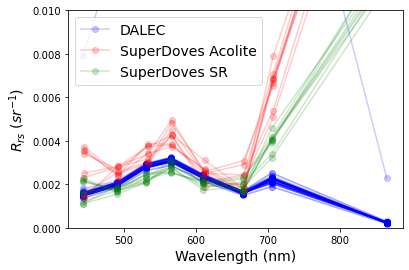

In [40]:
# use a coord near to the jetty
coord = [56.14725875854492, -3.920006513595581]

tables = dalecLoad.multiLogLoad('data/20-jun-22/Logs_20-Jun-22_20220623.dtf', dropNA=False)
spect_wavelengths = dalecLoad.load_DALEC_spect_wavelengths('data/20-jun-22/Logs_20-Jun-22_20220623.dtf')
RSR_doves = pd.read_csv('non-DALEC-data/RSR-Superdove.csv')

Plot_matchUp_SD_DALEC(tables['Log 1'], spect_wavelengths, RSR_doves, f, coord[0], coord[1])
plt.ylim(0, 0.01)

SD_raster_loading.plotSDRasterSpectraGrid('C:/Users/daa5/OneDrive - University of Stirling/PlanetData/\
airthrey-18-20-jun-22-SurfaceReflectance_psscene_analytic_8b_sr_udm2/files/\
20220620_102924_31_2423_3B_AnalyticMS_SR_8b_clip.tif', coord[0], coord[1])   

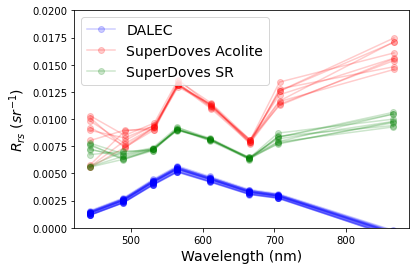

In [42]:
# let's look at leven data from 16th Jun
# take a coord near leven jetty
coord = [56.200045064586675, -3.415415138637228]

levenDALEC = dalecLoad.multiLogLoad('data/16-jun-22/Leven/LOG_0054-jetty.dtf', dropNA=False)['Log 1']
spect_wavelengths = dalecLoad.load_DALEC_spect_wavelengths('data/16-jun-22/Leven/LOG_0054-jetty.dtf')
RSR_doves = pd.read_csv('non-DALEC-data/RSR-Superdove.csv')

directory = 'C:/Users/daa5/\
OneDrive - University of Stirling/\
PlanetData/\
leven-12-jun-22-TOAR_psscene_analytic_8b_udm2/\
acolite/'

file = 'PlanetScope_2478_2022_06_12_11_00_22_L2R.nc'

f = netCDF4.Dataset(directory+file)

Plot_matchUp_SD_DALEC(levenDALEC, spect_wavelengths, RSR_doves, f, coord[0], coord[1])
plt.ylim(0, 0.02)

SD_raster_loading.plotSDRasterSpectraGrid('C:/Users/daa5/OneDrive - University of Stirling/\
PlanetData/leven-12-jun-22-surface-reflectance_psscene_analytic_8b_sr_udm2/files/\
20220612_110022_86_2478_3B_AnalyticMS_SR_8b_clip.tif', coord[0], coord[1])   

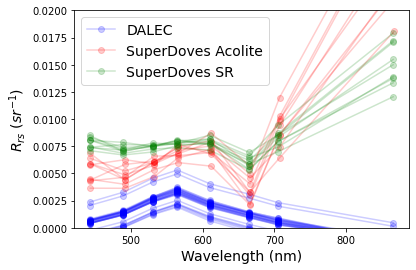

In [41]:
# let's look at gartmorn data from 16th Jun
# take a coord near gartmorn sample loc
coord = [56.126297409333425, -3.74922049688682]

DALEC = dalecLoad.multiLogLoad('data/16-jun-22/Gartmorn/LOG_0056.dtf', dropNA=False)['Log 1']
spect_wavelengths = dalecLoad.load_DALEC_spect_wavelengths('data/16-jun-22/Gartmorn/LOG_0056.dtf')
RSR_doves = pd.read_csv('non-DALEC-data/RSR-Superdove.csv')

directory = 'C:/Users/daa5/\
OneDrive - University of Stirling/\
PlanetData/\
gartmorn-18-Jun-22-TOAR-ACTUAL(first-one-was-actually-surf-refl)_psscene_analytic_8b_udm2/\
acolite/'

file = 'PlanetScope_249a_2022_06_18_10_58_18_L2R.nc'

f = netCDF4.Dataset(directory+file)

Plot_matchUp_SD_DALEC(DALEC, spect_wavelengths, RSR_doves, f, coord[0], coord[1])
plt.ylim(0, 0.02)

SD_raster_loading.plotSDRasterSpectraGrid('C:/Users/daa5/OneDrive - University of Stirling/\
PlanetData/gartmorn-18-Jun-22-TOAR_psscene_analytic_8b_sr_udm2/files/\
20220618_105818_44_249a_3B_AnalyticMS_SR_8b_clip.tif', coord[0], coord[1])   